Base de Grafos (neo4j) para analisis de relaciones entre artistas de rock y jazz

In [ ]:
# Librerias utilizadas
import sys
import pandas as pd 
import spotipy 
from neo4j import GraphDatabase
from spotipy.oauth2 import SpotifyClientCredentials
import time
import json
import numpy as np
import matplotlib.pyplot as plt

Coneccion con la API de Spotify 

In [ ]:
# Conecccion con spotify (obtener credenciales en spotify developer)
sp = spotipy.Spotify() 
cid ="pass"
secret = "passsecret"
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
sp.trace=False
artists = []


Consulta de los Artistas del Genero ROCK 

In [ ]:
# Este loop permite consultar la api en dos pasos, para obtener 25 musícos semilla (es aleatorio, por eso se adjuntaron las bases) primero
# y luego, para complementar su información y guardar esta informacion en una lista.
results = sp.search(q='genre:rock', type='artist', market='us',limit=25)
items = results['artists']['items']
for i in range (len(items)):
    time.sleep(.5)
    artist = items[i]
    artists.append(artist)


In [ ]:
# Con la lista anterior se crea el dataframe al cual se le suma una columna que indique el género para el grafo
data=pd.DataFrame(artists)
data['genero_grafos'] = 'rock'

Consulta de los Artistas del Genero JAZZ

In [ ]:
# Idem "Rock"
results = sp.search(q='genre:jazz', type='artist', market='us',limit=25)
items = results['artists']['items']
for i in range (len(items)):
    time.sleep(.5)
    artist = items[i]
    artists.append(artist)


In [ ]:
# Idem "Rock"
data_2=pd.DataFrame(artists)
data_2['genero_grafos'] = 'jazz'

In [ ]:
# Luego se combinan los datasets en uno solo, al cual se le remueven todos los caracteres especiales de los nombres
data = pd.concat([data, data_2], axis = 0, ignore_index=True)
remove_characters = ['(', ')', ',', ':', "'",',', '^', '*', '/', '%', '+', '-', "=~", "=", "~", "<>", "!=", "<", ">", "<=", ">=", "AND", "XOR", "OR", ',' or "}"]
for character in remove_characters:
    data['name'] = data['name'].str.replace(character, '')

Consulta de los Artistas relacionados con con las consultas anteriores. 

In [ ]:
# En este paso se recorre el dataframe anterior para buscar artistas relacionados a través del id
artistas_relaciones = pd.DataFrame()
for i, row in data[['id', 'genero_grafos']].iterrows():
     
    ra = sp.artist_related_artists(row['id'])
    for artist in ra['artists']:
            rb =pd.DataFrame([(key, var) for (key, L) in ra.items() for var in L],columns=['key', 'variable'])
            rb= pd.DataFrame({ key: pd.Series(val) for key, val in rb['variable'].items() }).transpose()
            rb['artista_original']=data['name']
            rb['genero_artista'] = row['genero_grafos']
            artistas_relaciones = pd.concat([artistas_relaciones, rb], axis= 0)  

In [ ]:
# Se repite el proceso de limpieza de nombres de artistas
for character in remove_characters:
    artistas_relaciones['name'] = artistas_relaciones['name'].str.replace(character, '')
    
artistas_relaciones

,external_urls,followers,genres,href,id,images,name,popularity,type,uri,artista_original,genero_artista
0,{'spotify': 'https://open.spotify.com/artist/4...,"{'href': None, 'total': 3821472}","[album rock, art rock, beatlesque, classic roc...",https://api.spotify.com/v1/artists/4x1nvY2FN8j...,4x1nvY2FN8jxqAFA0DA02H,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",John Lennon,78,artist,spotify:artist:4x1nvY2FN8jxqAFA0DA02H,The Beatles,rock
1,{'spotify': 'https://open.spotify.com/artist/7...,"{'href': None, 'total': 1693702}","[album rock, beatlesque, classic rock, folk ro...",https://api.spotify.com/v1/artists/7FIoB5PHdrM...,7FIoB5PHdrMZVC3q2HE5MS,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",George Harrison,70,artist,spotify:artist:7FIoB5PHdrMZVC3q2HE5MS,Fleetwood Mac,rock
2,{'spotify': 'https://open.spotify.com/artist/4...,"{'href': None, 'total': 3258608}","[album rock, art rock, beatlesque, classic roc...",https://api.spotify.com/v1/artists/4STHEaNw4mP...,4STHEaNw4mPZ2tzheohgXB,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Paul McCartney,78,artist,spotify:artist:4STHEaNw4mPZ2tzheohgXB,Imagine Dragons,rock
3,{'spotify': 'https://open.spotify.com/artist/6...,"{'href': None, 'total': 593019}","[album rock, beatlesque, bubblegum pop, classi...",https://api.spotify.com/v1/artists/6DbJi8AcN5A...,6DbJi8AcN5ANdtvJcwBSw8,"[{'height': 1000, 'url': 'https://i.scdn.co/im...",Ringo Starr,53,artist,spotify:artist:6DbJi8AcN5ANdtvJcwBSw8,Queen,rock
4,{'spotify': 'https://open.spotify.com/artist/3...,"{'href': None, 'total': 2897575}","[baroque pop, brill building pop, classic rock...",https://api.spotify.com/v1/artists/3oDbviiivRW...,3oDbviiivRWhXwIE8hxkVV,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Beach Boys,76,artist,spotify:artist:3oDbviiivRWhXwIE8hxkVV,Twenty One Pilots,rock
...,...,...,...,...,...,...,...,...,...,...,...,...
15,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 99549}","[bebop, big band, contemporary post-bop, cool ...",https://api.spotify.com/v1/artists/05E3NBxNMdn...,05E3NBxNMdnrPtxF9oraJm,"[{'height': 862, 'url': 'https://i.scdn.co/ima...",Lester Young,52,artist,spotify:artist:05E3NBxNMdnrPtxF9oraJm,Fall Out Boy,jazz
16,{'spotify': 'https://open.spotify.com/artist/6...,"{'href': None, 'total': 11406}","[bebop, cool jazz, hard bop, jazz, jazz quartet]",https://api.spotify.com/v1/artists/6nLkWu5DSXI...,6nLkWu5DSXItXcB6q2ISTO,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Gerry Mulligan Quartet,36,artist,spotify:artist:6nLkWu5DSXItXcB6q2ISTO,Thomas Rhett,jazz
17,{'spotify': 'https://open.spotify.com/artist/3...,"{'href': None, 'total': 61139}","[bebop, big band, contemporary post-bop, cool ...",https://api.spotify.com/v1/artists/34W7ZCX0LZe...,34W7ZCX0LZeJd8q6boKGOk,"[{'height': 1093, 'url': 'https://i.scdn.co/im...",Ben Webster,53,artist,spotify:artist:34W7ZCX0LZeJd8q6boKGOk,AJR,jazz
18,{'spotify': 'https://open.spotify.com/artist/5...,"{'href': None, 'total': 83002}","[adult standards, cool jazz, jazz, lounge, swi...",https://api.spotify.com/v1/artists/5bWApG9Vdsh...,5bWApG9Vdshhd1J50UnNf6,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Blossom Dearie,53,artist,spotify:artist:5bWApG9Vdshhd1J50UnNf6,Kelly Clarkson,jazz


In [ ]:
# El dataframe de trabajo utilizará los artistas semilla + los relacionados
artistas_nodos = artistas_relaciones.append(data)
artistas_nodos

,external_urls,followers,genres,href,id,images,name,popularity,type,uri,artista_original,genero_artista,genero_grafos
0,{'spotify': 'https://open.spotify.com/artist/4...,"{'href': None, 'total': 3821472}","[album rock, art rock, beatlesque, classic roc...",https://api.spotify.com/v1/artists/4x1nvY2FN8j...,4x1nvY2FN8jxqAFA0DA02H,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",John Lennon,78,artist,spotify:artist:4x1nvY2FN8jxqAFA0DA02H,The Beatles,rock,NaN
1,{'spotify': 'https://open.spotify.com/artist/7...,"{'href': None, 'total': 1693702}","[album rock, beatlesque, classic rock, folk ro...",https://api.spotify.com/v1/artists/7FIoB5PHdrM...,7FIoB5PHdrMZVC3q2HE5MS,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",George Harrison,70,artist,spotify:artist:7FIoB5PHdrMZVC3q2HE5MS,Fleetwood Mac,rock,NaN
2,{'spotify': 'https://open.spotify.com/artist/4...,"{'href': None, 'total': 3258608}","[album rock, art rock, beatlesque, classic roc...",https://api.spotify.com/v1/artists/4STHEaNw4mP...,4STHEaNw4mPZ2tzheohgXB,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Paul McCartney,78,artist,spotify:artist:4STHEaNw4mPZ2tzheohgXB,Imagine Dragons,rock,NaN
3,{'spotify': 'https://open.spotify.com/artist/6...,"{'href': None, 'total': 593019}","[album rock, beatlesque, bubblegum pop, classi...",https://api.spotify.com/v1/artists/6DbJi8AcN5A...,6DbJi8AcN5ANdtvJcwBSw8,"[{'height': 1000, 'url': 'https://i.scdn.co/im...",Ringo Starr,53,artist,spotify:artist:6DbJi8AcN5ANdtvJcwBSw8,Queen,rock,NaN
4,{'spotify': 'https://open.spotify.com/artist/3...,"{'href': None, 'total': 2897575}","[baroque pop, brill building pop, classic rock...",https://api.spotify.com/v1/artists/3oDbviiivRW...,3oDbviiivRWhXwIE8hxkVV,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Beach Boys,76,artist,spotify:artist:3oDbviiivRWhXwIE8hxkVV,Twenty One Pilots,rock,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,{'spotify': 'https://open.spotify.com/artist/2...,"{'href': None, 'total': 314669}","[edm, electropop, jamtronica, jazztronica, liv...",https://api.spotify.com/v1/artists/25oLRSUjJk4...,25oLRSUjJk4YHNUsQXk7Ut,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",GRiZ,63,artist,spotify:artist:25oLRSUjJk4YHNUsQXk7Ut,NaN,NaN,jazz
71,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 1341021}","[alternative hip hop, conscious hip hop, east ...",https://api.spotify.com/v1/artists/09hVIj6vWgo...,09hVIj6vWgoCDtT03h8ZCa,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",A Tribe Called Quest,69,artist,spotify:artist:09hVIj6vWgoCDtT03h8ZCa,NaN,NaN,jazz
72,{'spotify': 'https://open.spotify.com/artist/6...,"{'href': None, 'total': 349170}","[adult standards, contemporary vocal jazz, lou...",https://api.spotify.com/v1/artists/6u17YlWtW4o...,6u17YlWtW4oqFF5Hn9UU79,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Harry Connick Jr.,63,artist,spotify:artist:6u17YlWtW4oqFF5Hn9UU79,NaN,NaN,jazz
73,{'spotify': 'https://open.spotify.com/artist/2...,"{'href': None, 'total': 1207117}","[bebop, contemporary post-bop, cool jazz, free...",https://api.spotify.com/v1/artists/2hGh5VOeeqi...,2hGh5VOeeqimQFxqXvfCUf,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",John Coltrane,66,artist,spotify:artist:2hGh5VOeeqimQFxqXvfCUf,NaN,NaN,jazz


In [ ]:
# Se generan unas columnas auxiliares para asigar True/False a los géneros por artista (descubrimos que estos pueden tener varios géneros y repetirse en el dataset).
artistas_nodos['genres_dummy'] = np.where(pd.isnull(artistas_nodos.genero_grafos), artistas_nodos.genero_artista, artistas_nodos.genero_grafos)
artistas_nodos = pd.get_dummies(artistas_nodos, columns=['genres_dummy'])
artistas_nodos

,external_urls,followers,genres,href,id,images,name,popularity,type,uri,artista_original,genero_artista,genero_grafos,genres_dummy_jazz,genres_dummy_rock
0,{'spotify': 'https://open.spotify.com/artist/4...,"{'href': None, 'total': 3821472}","[album rock, art rock, beatlesque, classic roc...",https://api.spotify.com/v1/artists/4x1nvY2FN8j...,4x1nvY2FN8jxqAFA0DA02H,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",John Lennon,78,artist,spotify:artist:4x1nvY2FN8jxqAFA0DA02H,The Beatles,rock,NaN,0,1
1,{'spotify': 'https://open.spotify.com/artist/7...,"{'href': None, 'total': 1693702}","[album rock, beatlesque, classic rock, folk ro...",https://api.spotify.com/v1/artists/7FIoB5PHdrM...,7FIoB5PHdrMZVC3q2HE5MS,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",George Harrison,70,artist,spotify:artist:7FIoB5PHdrMZVC3q2HE5MS,Fleetwood Mac,rock,NaN,0,1
2,{'spotify': 'https://open.spotify.com/artist/4...,"{'href': None, 'total': 3258608}","[album rock, art rock, beatlesque, classic roc...",https://api.spotify.com/v1/artists/4STHEaNw4mP...,4STHEaNw4mPZ2tzheohgXB,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Paul McCartney,78,artist,spotify:artist:4STHEaNw4mPZ2tzheohgXB,Imagine Dragons,rock,NaN,0,1
3,{'spotify': 'https://open.spotify.com/artist/6...,"{'href': None, 'total': 593019}","[album rock, beatlesque, bubblegum pop, classi...",https://api.spotify.com/v1/artists/6DbJi8AcN5A...,6DbJi8AcN5ANdtvJcwBSw8,"[{'height': 1000, 'url': 'https://i.scdn.co/im...",Ringo Starr,53,artist,spotify:artist:6DbJi8AcN5ANdtvJcwBSw8,Queen,rock,NaN,0,1
4,{'spotify': 'https://open.spotify.com/artist/3...,"{'href': None, 'total': 2897575}","[baroque pop, brill building pop, classic rock...",https://api.spotify.com/v1/artists/3oDbviiivRW...,3oDbviiivRWhXwIE8hxkVV,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Beach Boys,76,artist,spotify:artist:3oDbviiivRWhXwIE8hxkVV,Twenty One Pilots,rock,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,{'spotify': 'https://open.spotify.com/artist/2...,"{'href': None, 'total': 314669}","[edm, electropop, jamtronica, jazztronica, liv...",https://api.spotify.com/v1/artists/25oLRSUjJk4...,25oLRSUjJk4YHNUsQXk7Ut,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",GRiZ,63,artist,spotify:artist:25oLRSUjJk4YHNUsQXk7Ut,NaN,NaN,jazz,1,0
71,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 1341021}","[alternative hip hop, conscious hip hop, east ...",https://api.spotify.com/v1/artists/09hVIj6vWgo...,09hVIj6vWgoCDtT03h8ZCa,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",A Tribe Called Quest,69,artist,spotify:artist:09hVIj6vWgoCDtT03h8ZCa,NaN,NaN,jazz,1,0
72,{'spotify': 'https://open.spotify.com/artist/6...,"{'href': None, 'total': 349170}","[adult standards, contemporary vocal jazz, lou...",https://api.spotify.com/v1/artists/6u17YlWtW4o...,6u17YlWtW4oqFF5Hn9UU79,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Harry Connick Jr.,63,artist,spotify:artist:6u17YlWtW4oqFF5Hn9UU79,NaN,NaN,jazz,1,0
73,{'spotify': 'https://open.spotify.com/artist/2...,"{'href': None, 'total': 1207117}","[bebop, contemporary post-bop, cool jazz, free...",https://api.spotify.com/v1/artists/2hGh5VOeeqi...,2hGh5VOeeqimQFxqXvfCUf,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",John Coltrane,66,artist,spotify:artist:2hGh5VOeeqimQFxqXvfCUf,NaN,NaN,jazz,1,0


Se eliminan Filas duplicadas y se extrae si el artista pertece a rock y/o jazz de la columna genero. 

In [ ]:
# Con las columnas auxiliares anteriores se hace un agrupamiento y se guarda un solo registro por artista
artistas_nodos = artistas_nodos.drop_duplicates(subset="name",  keep='last')
artistas_relaciones = artistas_relaciones.drop_duplicates(subset=["name","artista_original"],  keep='last')

In [ ]:
# Se completa la limpieza y creación de columnas auxiliares
aux_rock = []
aux_jazz = []
for i, row in artistas_nodos.iterrows():
    try:
        artistas_nodos.genres[i].index('rock')
        rock_ = 1
    except:
        rock_ = 0
    aux_rock.append(rock_)

artistas_nodos['genres_dummy_rock'] = aux_rock

for i, row in artistas_nodos.iterrows():
    try:
        artistas_nodos.genres[i].index('jazz')
        jazz_ = 1
    except:
        jazz_ = 0
    aux_jazz.append(jazz_)

artistas_nodos['genres_dummy_jazz'] = aux_jazz

In [ ]:
# Se graban los dataframes a disco para evitar la variabilidad de la semilla (no configurable) en las consultas
artistas_nodos.to_csv('artistas_nodos.csv')
artistas_relaciones.to_csv('artistas_relaciones.csv')
# artistas_nodos = pd.read_csv('artistas_nodos.csv')
# artistas_relaciones = pd.read_csv('artistas_relaciones.csv')



Se Conecta con la base de datos neo4j: 
nombre de base: spotify
uri="bolt://localhost:7687"
user="neo4j"
pwd="spotify"


In [ ]:
class Neo4jConnection:
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [ ]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="spotify")

Se generan los nodos: cada nodo es un artista, con las siguientes propiedades: 
nombre: nombre de la banda o artista. 
popularidad: porcentaje de popularidad, 100 maxima popularidad.  
rock:(si/no)
jazz:(si/no)

In [ ]:
# Las queryes se generarán iterando por el dataframe de trabajo evaluando los datos para crear las propiedades de los nodos.
for i, row in artistas_nodos[['name', 'popularity','genres_dummy_jazz','genres_dummy_rock']].drop_duplicates().iterrows():
    name = row['name']
    popularity= row['popularity']
    jazz= row['genres_dummy_jazz']
    rock=row['genres_dummy_rock']
    if jazz==1 and rock==1:

        conn.query("merge (n: Artist {name:'%s', popularity: '%s', Rock: 'si', Jazz: 'si'});" % ( name, popularity))
    elif jazz==0 and rock==1:

        conn.query("merge (n: Artist {name:'%s', popularity: '%s', Rock: 'si'});" % ( name, popularity))
       
    else :

        conn.query("merge (n: Artist {name:'%s', popularity: '%s', Jazz: 'si'});" % ( name, popularity))

Se genera la relacion entre artistas como relacionado. 

In [ ]:
# De la misma manera se generarán las relaciones iterando sobre los datos y escribiendo sobre los nodos recién creados
artista_original=[]
name=[]
for i, row in artistas_relaciones[['artista_original', 'name']].drop_duplicates().iterrows():
    artista_original = row['artista_original']
    name = row['name']
  
    conn.query("MATCH (a:Artist {name: '%s'}) MATCH (b:Artist {name: '%s'}) merge (a)-[:relacionado]->(b)"% (artista_original, name))


Se empiezan los analisis del grafo generado

In [ ]:
# Se validan los nodos creados
conn.query("MATCH (n:Artist) RETURN count(n) AS cantidad_artistas")

[<Record cantidad_artistas=1067>]

In [ ]:
# Asimismo se evaluan las propiedades de los nodos
conn.query("call db.schema.nodeTypeProperties")

[<Record nodeType=':`Artist`' nodeLabels=['Artist'] propertyName='Rock' propertyTypes=['String'] mandatory=False>,
 <Record nodeType=':`Artist`' nodeLabels=['Artist'] propertyName='Jazz' propertyTypes=['String'] mandatory=False>,
 <Record nodeType=':`Artist`' nodeLabels=['Artist'] propertyName='popularity' propertyTypes=['String'] mandatory=True>,
 <Record nodeType=':`Artist`' nodeLabels=['Artist'] propertyName='name' propertyTypes=['String'] mandatory=True>]

In [ ]:
# Se verifica que todos tienen nombre y popularidad (un dato de spotify) y que la cantidad de músicos de rock o jazz es correcta
conn.query("MATCH (n) RETURN count(n.name), count(n.popularity), count(n.Rock), count(n.Jazz)")

[<Record count(n.name)=1067 count(n.popularity)=1067 count(n.Rock)=377 count(n.Jazz)=690>]

In [ ]:
# Las relaciones creadas son 2914.
conn.query("MATCH ()-[f:relacionado]->() RETURN count(f) AS total_relaciones")

[<Record total_relaciones=2914>]

In [ ]:
# Tal como se definió, las relacione no tienen propiedades
conn.query("call db.schema.relTypeProperties")

[<Record relType=':`relacionado`' propertyName=None propertyTypes=None mandatory=False>]

In [ ]:
# Se observan los artistas sin relaciones
conn.query("MATCH (p:Artist) WHERE NOT (p)-[]-() RETURN p.name")

[<Record p.name='Hozier'>,
 <Record p.name='John Mayer'>,
 <Record p.name='Hozier'>,
 <Record p.name='John Mayer'>,
 <Record p.name='Michael Bublé'>,
 <Record p.name='Leslie Odom Jr.'>,
 <Record p.name='Norah Jones'>,
 <Record p.name='Earth Wind & Fire'>,
 <Record p.name='Kenny G'>,
 <Record p.name='Grover Washington Jr.'>,
 <Record p.name='Tom Misch'>,
 <Record p.name='GRiZ'>,
 <Record p.name='A Tribe Called Quest'>,
 <Record p.name='Miles Davis'>]

In [ ]:
# Se evaluan los artistas con más relaciones creadas (el top 10)
top10 = pd.DataFrame([dict(_) for _ in conn.query("MATCH (p:Artist)-[]-(q) RETURN p.name, count(q) as relaciones order by relaciones desc limit 10")])
top10  

,p.name,relaciones
0,AJR,156
1,Panic! At The Disco,156
2,Led Zeppelin,154
3,Elvis Presley,154
4,Twenty One Pilots,152
5,Metallica,152
6,Fall Out Boy,150
7,Florida Georgia Line,150
8,Elton John,150
9,Queen,150


In [ ]:
# Para comprender mejor como es el grafo creado, se calcula el diámetro
conn.query("MATCH (a:Artist), (b:Artist) WHERE id(a) > id(b) MATCH p=shortestPath((a)-[:relacionado*]-(b)) RETURN MAX(length(p)) AS diametro")

[<Record diametro=5>]

In [ ]:
# Calculamos las duplas de nodos con distancia 5, obteniendo un dataframe que expresa las relaciones en terminos de origen-destino de forma duplicada (A - B y B - A).
diametro_maximo = pd.DataFrame([dict(_) for _ in conn.query("MATCH (a:Artist), (b:Artist) WHERE id(a) > id(b) MATCH p=shortestPath((a)-[:relacionado*]-(b))  with a, b, MAX(length(p)) as diametro where diametro = 5 return a.name AS desde, b.name AS hasta")])
diametro_maximo


,desde,hasta
0,Gerard Way,The Maine
1,Boys Like Girls,Gerard Way
2,Marianas Trench,Gerard Way
3,Airbourne,Gerard Way
4,Airbourne,You Me At Six
...,...,...
21436,The Wanted,Declan McKenna
21437,Jonas Blue,Dayglow
21438,Jonas Blue,Olly Murs
21439,Zedd,HUNNY


In [ ]:
# Para acotar esta tabla se puede ejecutar el siguiente comando que elimina duplicidades
aux_diametro_maximo = diametro_maximo.loc[~pd.DataFrame(np.sort(diametro_maximo.iloc[:, :2])).duplicated()]
aux_diametro_maximo

,desde,hasta
0,Gerard Way,The Maine
1,Boys Like Girls,Gerard Way
2,Marianas Trench,Gerard Way
3,Airbourne,Gerard Way
4,Airbourne,You Me At Six
...,...,...
17283,Art Blakey,Judy Garland
17284,Art Blakey,Jordan Rakei
17285,Art Blakey,Big Gigantic
17286,Art Blakey,De La Soul


In [ ]:
# Esto permite evaluar rápidamente que artistas se encuentran en los extremos y que artistas tienden a ser centrales en el nodo
aux_diametro_maximo = pd.concat([aux_diametro_maximo.desde, aux_diametro_maximo.hasta], axis=0)
aux_diametro_maximo.value_counts()

Teddy Wilson                146
Gerard Way                  146
The Emotions                146
Jeff Lorber                 146
Del The Funky Homosapien    146
                           ... 
Kreator                      20
Kurt Cobain                  20
PREP                         20
The Four Aces                20
Space Jesus                  20
Length: 415, dtype: int64

In [ ]:
# El cálculo de nodos pivotales muestra aquellos tríos de nodos que conforman el camino más corto entre dos nodos a-b a través de c
nodos_pivotales = pd.DataFrame([dict(_) for _ in conn.query("MATCH (a:Artist), (b:Artist) WHERE id(a) > id(b) MATCH p=allShortestPaths((a)-[:relacionado*]-(b)) WITH collect(p) AS paths, a, b MATCH (c:Artist) WHERE all(x IN paths WHERE c IN nodes(x)) AND NOT c IN [a,b] RETURN a.name, c.name AS PivotalNode, b.name")])
nodos_pivotales

,a.name,PivotalNode,b.name
0,Guns N Roses,Julie London,Gerard Way
1,Airbourne,Sammy Davis Jr.,Never Shout Never
2,Ozzy Osbourne,Dave Brubeck,Gerard Way
3,Scorpions,Freddie Hubbard,Airbourne
4,Scorpions,Peggy Lee,Judas Priest
...,...,...,...
54613,Mayday Parade,Dave Brubeck,Nick Jonas
54614,We The Kings,Mel Tormé,Dayglow
54615,We The Kings,Mel Tormé,Olly Murs
54616,The Cab,Kay Starr,MARINA


In [ ]:
# Para aplicar algunos algoritmos debemos crear el grafo sobre el cual los aplicaremos a través de la siguiente sentencia
conn.query("CALL gds.graph.create.cypher('gdm_spotify', 'MATCH (n:Artist) RETURN id(n) AS id', 'MATCH (a:Artist)-[:relacionado]-(b:Artist) RETURN id(a) AS source, id(b) AS target') YIELD graphName, nodeCount, relationshipCount, createMillis")

Query failed: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.create.cypher`: Caused by: java.lang.IllegalArgumentException: A graph with name 'gdm_spotify' already exists.}


In [ ]:
# Calculamos y guardamos la propiedad Grado
conn.query("CALL gds.alpha.degree.write({nodeProjection: 'Artist', relationshipProjection: { RELACIONADO: { type: 'relacionado', orientation: 'UNDIRECTED'}}, writeProperty: 'grado'})")

[<Record nodes=1067 createMillis=8400 computeMillis=57 writeMillis=3958 writeProperty='grado'>]

In [ ]:
# Calculamos y guardamos la propiedad Pagerank
conn.query("CALL gds.pageRank.write('gdm_spotify',{writeProperty: 'pagerank'}) YIELD nodePropertiesWritten, ranIterations")

[<Record nodePropertiesWritten=1067 ranIterations=20>]

In [ ]:
# Calculamos y guardamos la propiedad Closeness
conn.query("CALL gds.alpha.closeness.write('gdm_spotify',{writeProperty: 'closeness'}) YIELD nodes, createMillis, computeMillis, writeMillis")

[<Record nodes=1067 createMillis=0 computeMillis=577 writeMillis=288>]

# Louvain: cálculo de comunidades

In [ ]:
# Este algoritmo calcula comunidades dentro del grafo, lo vamos a utilizar para agrupar y analizar los resultados
conn.query("CALL gds.louvain.write('gdm_spotify', { writeProperty: 'community' }) YIELD communityCount, modularity, modularities")

[<Record communityCount=29 modularity=0.6496604327486316 modularities=[0.6423038096444919, 0.6496604327486316]>]

In [ ]:
# Se crea un dataset que ofrezca parte de la información creada en forma de tabla para el análisis de los resultados
dataset = pd.DataFrame([dict(_) for _ in conn.query("MATCH (x: Artist)-[r]-()  RETURN x.name as name, x.grado as grado, x.pagerank as pagerank, x.closeness as closeness, x.popularity as popularidad, x.community as comunidad")])
dataset.popularidad = dataset.popularidad.astype(int)
dataset.drop_duplicates(inplace=True)
dataset

,name,grado,pagerank,closeness,popularidad,comunidad
0,The Maine,4.0,0.691611,0.276406,60,898
4,Gerard Way,2.0,0.437814,0.250715,58,900
6,Boys Like Girls,4.0,0.667227,0.271414,62,898
10,3OH!3,4.0,0.681858,0.288219,65,902
14,Marianas Trench,2.0,0.424454,0.269123,60,289
...,...,...,...,...,...,...
3718,ACDC,75.0,12.252220,0.362384,85,903
3793,Arctic Monkeys,72.0,13.127987,0.341226,86,904
3865,Red Hot Chili Peppers,73.0,11.078600,0.356731,84,898
3938,Pink Floyd,73.0,12.540228,0.358555,82,906


In [ ]:
# Grado y Pagerank se ven altamente correlacionados, mientras que Closeness-Grado y Closeness-Pagerank presentan una correlación alta.
# Esperábamos encontrar alguna correlación alta de popularidad con alguna métrica, para descubrir si tiene alguna lógica de grafo pero no resulta evidente.
dataset[['grado', 'pagerank', 'closeness', 'popularidad']].corr().round(3)

,grado,pagerank,closeness,popularidad
grado,1.000,0.998,0.799,0.335
pagerank,0.998,1.000,0.783,0.332
closeness,0.799,0.783,1.000,0.311
popularidad,0.335,0.332,0.311,1.000


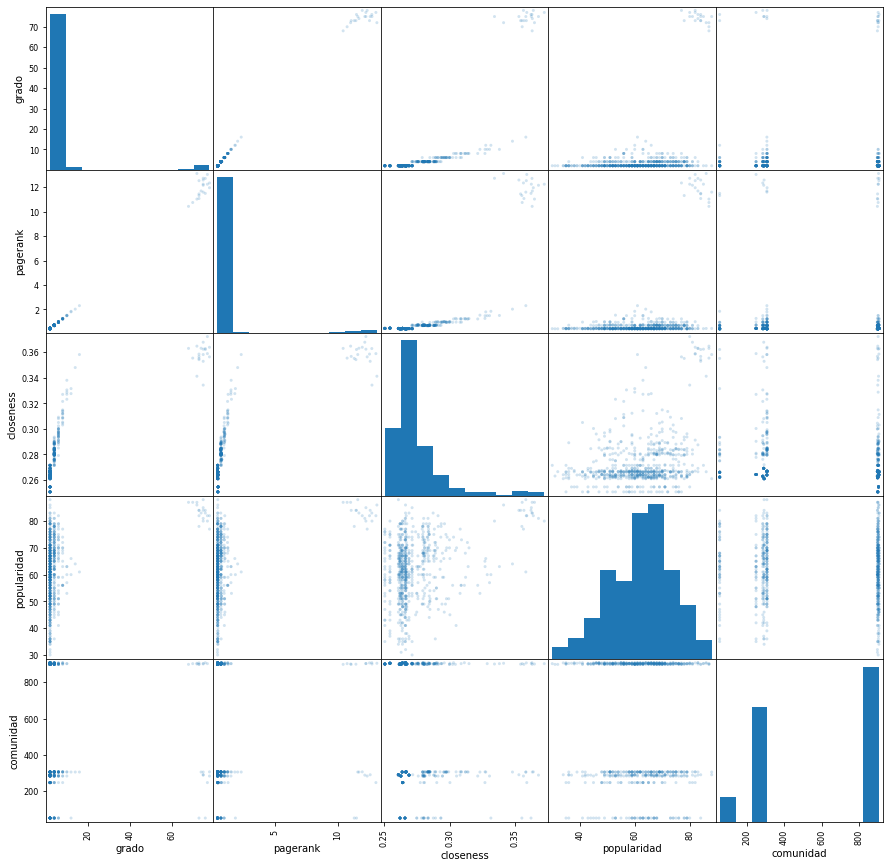

In [ ]:
# De esta manera es posible observar todas las combinaciones de scatter plot + histograma de las métricas descargadas (hasta comunidad porque es un número entero).
# De forma esperable se ven claras tendencias lineales entre algunas variables (Pagerank y grado por ejemplo), y se observa la concentración de valores de pagerank y grado en los extremos.
from pandas.plotting import scatter_matrix
scatter_matrix(dataset, alpha = 0.2, figsize = (15,15), diagonal = 'hist')
plt.show()

In [ ]:
# Observamos la cantidad de nodos por comunidad, relativamente pareja
dataset.comunidad.value_counts()

306    72
902    63
898    61
900    57
53     57
307    50
904    44
284    44
906    38
248    38
907    35
903    33
291    31
289    29
899    26
Name: comunidad, dtype: int64

In [ ]:
# Finalmente analizamos las métricas agrupando por el nro de comunidad en busca de algún otro patrón
aux_comunidades = dataset.groupby('comunidad').describe().round(2).T
aux_comunidades

comunidad            53     248    284    289    291    306    307    898  \
grado       count  57.00  38.00  44.00  29.00  31.00  72.00  50.00  61.00   
            mean    5.35   4.45   5.14   4.86   4.61   5.57   5.36   5.13   
            std    13.41  12.15  11.42  13.52  13.08  12.07  10.67  12.23   
            min     2.00   2.00   2.00   2.00   2.00   2.00   2.00   2.00   
            25%     2.00   2.00   2.00   2.00   2.00   2.00   2.00   2.00   
            50%     2.00   2.00   2.00   2.00   2.00   2.00   4.00   2.00   
            75%     4.00   2.00   4.00   2.00   2.00   4.00   4.00   4.00   
            max    76.00  77.00  78.00  75.00  75.00  75.00  78.00  73.00   
pagerank    count  57.00  38.00  44.00  29.00  31.00  72.00  50.00  61.00   
            mean    0.91   0.83   0.88   0.87   0.86   0.94   0.89   0.87   
            std     2.03   2.04   1.79   2.17   2.18   1.86   1.62   1.85   
            min     0.41   0.44   0.42   0.42   0.43   0.41   0.41   0.41   
            25%     0.41   0.44   0.42   0.42   0.43   0.41   0.41   0.41   
            50%     0.41   0.44   0.42   0.42   0.43   0.42   0.67   0.41   
            75%     0.67   0.44   0.71   0.42   0.43   0.68   0.69   0.67   
            max    11.50  13.05  12.35  12.16  12.59  11.69  11.96  11.08   
closeness   count  57.00  38.00  44.00  29.00  31.00  72.00  50.00  61.00   
            mean    0.27   0.27   0.28   0.28   0.27   0.28   0.28   0.27   
            std     0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   
            min     0.26   0.26   0.26   0.27   0.26   0.26   0.27   0.26   
            25%     0.26   0.26   0.26   0.27   0.26   0.26   0.27   0.26   
            50%     0.27   0.26   0.26   0.27   0.26   0.27   0.28   0.27   
            75%     0.28   0.26   0.28   0.27   0.26   0.28   0.29   0.28   
            max     0.36   0.36   0.36   0.37   0.35   0.36   0.36   0.36   
popularidad count  57.00  38.00  44.00  29.00  31.00  72.00  50.00  61.00   
            mean   62.51  59.42  63.86  60.76  61.84  63.72  64.50  62.36   
            std    11.55  11.31  10.80  11.62  12.90  10.42  10.12  11.29   
            min    35.00  35.00  41.00  36.00  34.00  36.00  41.00  31.00   
            25%    57.00  51.00  54.75  53.00  54.00  58.00  57.25  56.00   
            50%    63.00  61.00  66.50  61.00  64.00  64.50  64.50  62.00   
            75%    68.00  65.00  73.00  68.00  71.00  70.00  72.75  70.00   
            max    84.00  82.00  82.00  83.00  88.00  88.00  82.00  87.00   

comunidad            899    900    902    903    904    906    907  
grado       count  26.00  57.00  63.00  33.00  44.00  38.00  35.00  
            mean    4.96   4.86   5.32   4.70   4.09   4.50   4.57  
            std    13.89  13.24  12.60  12.65  10.52  11.47  12.51  
            min     2.00   2.00   2.00   2.00   2.00   2.00   2.00  
            25%     2.00   2.00   2.00   2.00   2.00   2.00   2.00  
            50%     2.00   2.00   2.00   2.00   2.00   2.00   2.00  
            75%     2.00   2.00   4.00   4.00   2.50   4.00   2.00  
            max    73.00  75.00  77.00  75.00  72.00  73.00  76.00  
pagerank    count  26.00  57.00  63.00  33.00  44.00  38.00  35.00  
            mean    0.87   0.87   0.91   0.85   0.82   0.85   0.85  
            std     2.16   2.13   1.95   2.05   1.90   1.95   2.08  
            min     0.42   0.41   0.41   0.43   0.46   0.44   0.43  
            25%     0.42   0.41   0.41   0.43   0.46   0.44   0.43  
            50%     0.42   0.44   0.42   0.43   0.46   0.44   0.43  
            75%     0.42   0.44   0.68   0.69   0.52   0.70   0.43  
            max    11.45  12.74  12.25  12.25  13.13  12.54  12.72  
closeness   count  26.00  57.00  63.00  33.00  44.00  38.00  35.00  
            mean    0.27   0.26   0.28   0.27   0.26   0.27   0.27  
            std     0.02   0.02   0.02   0.02   0.02   0.02   0.02  
            min     0.26   0.25   0.26   0.27   0.25   0.26   0.27  
         